In [2]:
%cd "../"
%pwd

import numpy as np
import matplotlib.pyplot as plt

import io 
import pandas as pd  
import pyreadr

from load_data import *
from pred_score import *
from Filter_FS import *
from hybrid_FS import *
from overlap_genes import *
from crossValidation import *

C:\Users\alexi\Desktop\Memory_genes\src


ModuleNotFoundError: No module named 'genetic_selection'

In [ ]:
#Fixing seed to get reproducible results
random.seed(3)
np.random.seed(3)

# Baseline with preselected genes 

In [3]:
#Load preprocess data
LSK = np.array(pd.read_csv ('../data/processed_data/LSK.csv'))
y = np.array(LSK[:,-1],dtype=int)
LSK = LSK[:,0:-1]

3

In [4]:
#Predict and evaluate
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(LSK,y)

In [5]:
print(LSK.shape, len(pred))
acc = model.score_
print(acc)

(3383, 7570) 3383
0.05939139559286464


In [6]:
print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))

TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR =  (283.0, 4482.0, 0.06314145470771977, 0.32678983833718245, 0.995265014457447, 0.05939139559286464, 0.9993815452246381, 0.9406086044071353, 0.6732101616628176)


# Mutual information maximizer (MIM)

test 0.15856423600945915 0.014037291999837494
TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR =  (350.0, 3870.0, 0.09043927648578812, 0.28112449799196787, 0.9973041541104336, 0.08293838862559241, 0.9993752473706291, 0.9170616113744076, 0.7188755020080321)


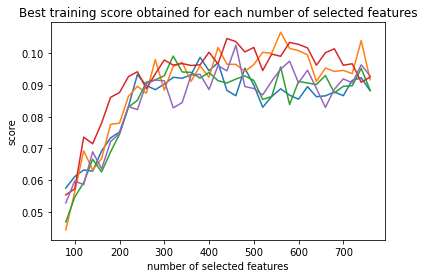

In [7]:
#Define parameters for MIM method
N = np.arange(80,768,20)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_neighbors': 3, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,LSK, FamiliesClusters, compute_precision,True, 5,  MIM, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = LSK[:, subset]
pred = model.fit_predict(x_subset,y)

print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))

# Anova F test

test 0.19432911073508197 0.01161584317199877
TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR =  (452.0, 3472.0, 0.13018433179723501, 0.2886334610472541, 0.9980884225687262, 0.11518858307849134, 0.9993858682439305, 0.8848114169215087, 0.7113665389527458)


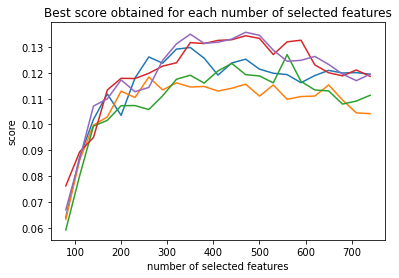

In [8]:
#Define parameters for ANOVA method
N = np.arange(80,768,30)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,LSK, FamiliesClusters, compute_precision,True, 5,  ANOVA, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = LSK[:, subset]
pred = model.fit_predict(x_subset,y)

print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))    

In [9]:
#Create .csv with names of this subset
best_subset = subset
get_best_genes_names(best_subset, '../data/processed_data/LSKgenes_interest.csv', '../data/optimized_subsets/LSKgenes_best.csv')

# Optimization without CV

In [38]:
def optimization_onlibrary(name:str, norm_path:str, family_info_path:str, flip:bool, N:np.array):
    print(name)
    #Load data
    norm_path = '../data/family_datasets/Weinreb_libraries_norm_lifted/' + norm_path
    norm  = pyreadr.read_r(norm_path)
    norm = norm[None]

    family_info_path = '../data/family_datasets/Family_info/' + family_info_path
    family_info = pyreadr.read_r(family_info_path)
    family_info = np.array(family_info['WORK_clones'])
    if flip == True:
        family_info[:,[0,1]] = family_info[:,[1,0]]
    
    families, count = np.unique(family_info[:,0], return_counts=True)
    family_interest = families[np.logical_and(count > 1, count < 6)]
    
    #Norm data with only the cells belonging to the family of interest
    cells_interest = []
    for fam in family_interest:
        cell = family_info[fam == family_info[:,0]][:,1]
        cells_interest.append(cell)
    cells_interest = [item for sublist in cells_interest for item in sublist]
        
    norm = norm.loc[:,cells_interest]
    y = pd.DataFrame(np.zeros((norm.shape[1],)), index= norm.columns)
    family_info = pd.DataFrame(family_info[:,0], index = family_info[:,1])
    y.loc[cells_interest] = (family_info.loc[cells_interest])
    y = np.squeeze(np.array(y))   

    #Remove all genes that are not expressed in at least percentage (default 50%) of the mESC cells
    gene_expressed = filter_norm_data(norm,0.05)
    norm = norm[gene_expressed]

    #Store the name of genes of interest
    genes_interest = norm.index.values #get name of genes
    genes_interest = pd.DataFrame(genes_interest)
    output_gene = '../data/processed_data/' + name + 'genes_interest.csv'
    genes_interest.to_csv(output_gene, index=False)
    
    norm_array = np.array(norm).T
    
    #Run MIM optimization
    '''N = np.arange(100,3000,25)
    best_subset, best_score = MIM(y, norm_array, FamiliesClusters, compute_precision, True, N, 3, plot=True)
    plt.show()
    print(len(best_subset), best_score)

    #Only keep the optimized genes
    norm_subset = norm_array[:,best_subset]

    subset = np.ones((len(best_subset),))
    subsets = subsampling_genes(subset, 101, 0.25)
    
    #Predicting once 
    model = FamiliesClusters(np.unique(y),compute_precision,True)
    pred = model.fit_predict(np.array(norm_subset),np.array(y))
    print('Clustering once')
    print('precision: ', model.score_, ' recovery: ', model.recovery)
    
    #Predicting 101 times and majority vote (cutoff = 0.5)
    model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
    result  = model.fit_predict(X = np.array(norm_subset), y= np.array(y))
    print('Clustering 101 times and majority vote')
    print('precision: ', model.score_, ' recovery: ', model.recovery)
    
    output_MIM = '../data/optimized_subsets/' + name + 'genes_bestMIM.csv'
    get_best_genes_names(best_subset, output_gene, output_MIM)'''
    
    #Run ANOVA optimization
    #N = np.arange(100,3000,25)
    best_subset, best_score = ANOVA(y, norm_array, FamiliesClusters, compute_precision, True, N, plot=True)
    plt.show()
    print(len(best_subset), best_score)

    #Only keep the optimized genes
    norm_subset = norm_array[:,best_subset]

    subset = np.ones((len(best_subset),))
    subsets = subsampling_genes(subset, 101, 0.25)
    
    #Predicting once 
    model = FamiliesClusters(np.unique(y),compute_precision,True)
    pred = model.fit_predict(np.array(norm_subset),np.array(y))
    print('Clustering once')
    print('precision: ', model.score_, ' recovery: ', model.recovery)
    
    #Predicting 101 times and majority vote (cutoff = 0.5)
    model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
    result  = model.fit_predict(X = np.array(norm_subset), y= np.array(y))
    print('Clustering 101 times and majority vote')
    print('precision: ', model.score_, ' recovery: ', model.recovery)
    
    output_ANOVA = '../data/optimized_subsets/' + name + 'genes_bestANOVA.csv'
    get_best_genes_names(best_subset, output_gene, output_ANOVA)

In [7]:
name_library = ['LSK_D2_exp1_library_LSK_d2_1','LSK_D2_exp1_library_LSK_d2_2','LSK_D2_exp1_library_LSK_d2_3','LSK_D2_exp2_library_d2A_1','LSK_D2_exp2_library_d2A_2','LSK_D2_exp2_library_d2A_3','LSK_D2_exp2_library_d2A_4','LSK_D2_exp2_library_d2A_5',
                'LSK_D2_exp2_library_d2B_1','LSK_D2_exp2_library_d2B_2','LSK_D2_exp2_library_d2B_3','LSK_D2_exp2_library_d2B_4','LSK_D2_exp2_library_d2B_5']

libraries_LSK = ['Weinreb_LSK_D2_exp1_library_LSK_d2_1_norm.rds','Weinreb_LSK_D2_exp1_library_LSK_d2_2_norm.rds','Weinreb_LSK_D2_exp1_library_LSK_d2_3_norm.rds','Weinreb_LSK_D2_exp2_library_d2A_1_norm.rds','Weinreb_LSK_D2_exp2_library_d2A_2_norm.rds',
                 'Weinreb_LSK_D2_exp2_library_d2A_3_norm.rds','Weinreb_LSK_D2_exp2_library_d2A_4_norm.rds','Weinreb_LSK_D2_exp2_library_d2A_5_norm.rds','Weinreb_LSK_D2_exp2_library_d2B_1_norm.rds','Weinreb_LSK_D2_exp2_library_d2B_2_norm.rds','Weinreb_LSK_D2_exp2_library_d2B_3_norm.rds',
                 'Weinreb_LSK_D2_exp2_library_d2B_4_norm.rds', 'Weinreb_LSK_D2_exp2_library_d2B_5_norm.rds']
family_info_LSK = ['family_info_Weinreb_LSK_D2_exp1_library_LSK_d2_1.RData','family_info_Weinreb_LSK_D2_exp1_library_LSK_d2_2.RData','family_info_Weinreb_LSK_D2_exp1_library_LSK_d2_3.RData','family_info_Weinreb_LSK_D2_exp2_library_d2A_1.RData',
                   'family_info_Weinreb_LSK_D2_exp2_library_d2A_2.RData','family_info_Weinreb_LSK_D2_exp2_library_d2A_3.RData','family_info_Weinreb_LSK_D2_exp2_library_d2A_4.RData','family_info_Weinreb_LSK_D2_exp2_library_d2A_5.RData','family_info_Weinreb_LSK_D2_exp2_library_d2B_1.RData',
                   'family_info_Weinreb_LSK_D2_exp2_library_d2B_2.RData','family_info_Weinreb_LSK_D2_exp2_library_d2B_3.RData','family_info_Weinreb_LSK_D2_exp2_library_d2B_4.RData','family_info_Weinreb_LSK_D2_exp2_library_d2B_5.RData']

## First Expreriment

In [8]:
def prediction_onlibrary(name:str, norm_path:str, family_info_path:str, flip:bool):
    
    norm_path = '../data/family_datasets/Weinreb_libraries_norm_lifted/' + norm_path
    norm  = pyreadr.read_r(norm_path)
    norm = norm[None]

    family_info_path = '../data/family_datasets/Family_info/' + family_info_path
    family_info = pyreadr.read_r(family_info_path)
    family_info = np.array(family_info['WORK_clones'])
    if flip == True:
        family_info[:,[0,1]] = family_info[:,[1,0]]
    
    families, count = np.unique(family_info[:,0], return_counts=True)
    family_interest = families[np.logical_and(count > 1, count < 6)]
    
    #Norm data with only the cells belonging to the family of interest
    cells_interest = []
    for fam in family_interest:
        cell = family_info[fam == family_info[:,0]][:,1]
        cells_interest.append(cell)
    cells_interest = [item for sublist in cells_interest for item in sublist]
        
    norm = norm.loc[:,cells_interest]
    y = pd.DataFrame(np.zeros((norm.shape[1],)), index= norm.columns)
    family_info = pd.DataFrame(family_info[:,0], index = family_info[:,1])
    y.loc[cells_interest] = (family_info.loc[cells_interest])
    y = np.squeeze(np.array(y))   

    print(name)
    
    norm.to_csv('../data/merged_data/' + name + '.csv', index=True)
    pd.DataFrame(y).to_csv('../data/merged_data/y_' + name + '.csv', index=False)
    
    p_value_path = p_value_path = '../data/Characteristics_masterfiles/Memory_genes/P_value_estimate_CV2_ofmeans_' + name + '.txt'
    memory = read_memory_genes(p_value_path)
    memory_genes = get_memory_genes(memory) 

    pd.DataFrame(memory_genes).to_csv('../data/CV2genes/' + name + '_CV2mean.csv', index = False)
    
    norm = pd.read_csv ('../data/merged_data/' + name + '.csv')
    norm = norm.set_index('Unnamed: 0')
    y = np.squeeze(np.array(pd.read_csv ('../data/merged_data/y_' + name + '.csv')))
    print(norm.shape, y.shape)
    
    gene_ML = np.squeeze(pd.read_csv ('../data/optimized_subsets/' + name + 'genes_best.csv'))
    norm_ML = np.array(norm.loc[gene_ML]).T
    subset = np.ones((len(gene_ML),))
    subsets_ML = subsampling_genes(subset, 100, 0.25)
    print(norm_ML.shape)
 
    gene_CV2 = np.squeeze(pd.read_csv ('../data/CV2genes/' + name + '_CV2mean.csv'))
    norm_CV2 = np.array(norm.loc[gene_CV2]).T
    subset = np.ones((len(gene_CV2),))
    subsets_CV2 = subsampling_genes(subset, 100, 0.25)
    print(norm_CV2.shape)

    #Predict family using ML and CV2 sets
    model_ML = EnsemblingHierarchical(np.unique(y),compute_precision,True, subsets = subsets_ML, ensembling='voting', threshold_voting = 0.5)
    result_ML = model_ML.fit_predict(X = norm_ML, y= y)

    model_CV2 = EnsemblingHierarchical(np.unique(y),compute_precision,True, subsets = subsets_CV2, ensembling='voting', threshold_voting = 0.5)
    result_CV2 = model_CV2.fit_predict(X = norm_CV2, y= y)

    #Compute scores
    score = [model_ML.score_, compute_sensitivity(y, result_ML), model_CV2.score_, compute_sensitivity(y, result_CV2)] 
    
    return score


In [11]:
scores = []
lib_name = []
for i in range(0,3):
    score  = prediction_onlibrary(name=name_library[i], norm_path=libraries_LSK[i], family_info_path=family_info_LSK[i], flip=False)
    scores.append(score); lib_name.append(name_library[i])

LSK_D2_exp1_library_LSK_d2_1
(23867, 362) (362,)
(23867, 362) (362,)
(362, 1635)
(362, 1646)
LSK_D2_exp1_library_LSK_d2_2
(23867, 550) (550,)
(23867, 550) (550,)
(550, 1322)
(550, 1799)
LSK_D2_exp1_library_LSK_d2_3
(23867, 312) (312,)
(23867, 312) (312,)
(312, 1565)
(312, 1373)


In [12]:
names_scores = ['ML precision', 'ML recovery', 'CV2 precision', 'CV2 recovery']; 
scores = pd.DataFrame(scores, columns = names_scores, index = lib_name)
scores.to_csv('LSK1_pred.csv', index = True)

LSK_exp1_d2_1


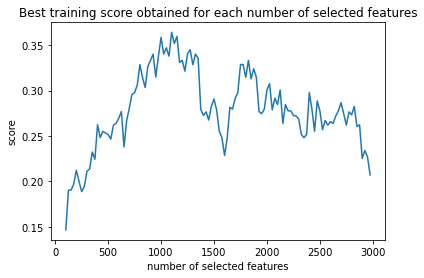

1100 0.36428571428571427
Clustering once
precision:  0.36428571428571427  recovery:  0.7734806629834254
Clustering 101 times and majority vote
precision:  0.6666666666666666  recovery:  0.26519337016574585


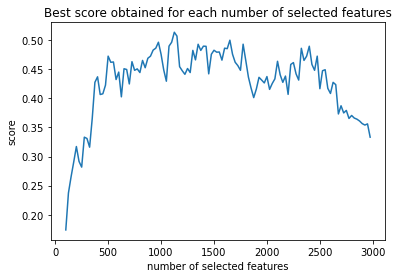

1125 0.5136986301369864
Clustering once
precision:  0.5136986301369864  recovery:  0.8066298342541437
Clustering 101 times and majority vote
precision:  0.7761194029850746  recovery:  0.3701657458563536
LSK_exp1_d2_2


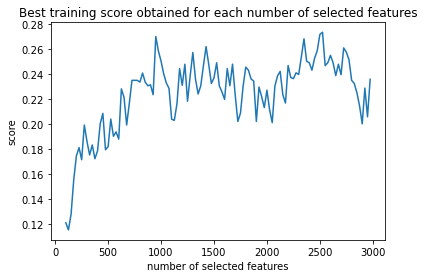

2525 0.2731707317073171
Clustering once
precision:  0.2731707317073171  recovery:  0.7454545454545455
Clustering 101 times and majority vote
precision:  0.625  recovery:  0.20363636363636364


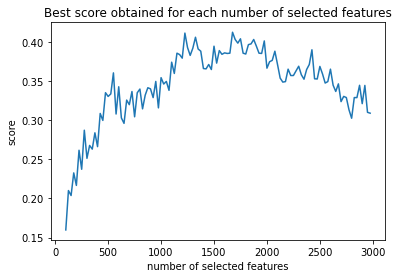

1675 0.41203703703703703
Clustering once
precision:  0.41203703703703703  recovery:  0.7854545454545454
Clustering 101 times and majority vote
precision:  0.6835443037974683  recovery:  0.2872727272727273
LSK_exp1_d2_3


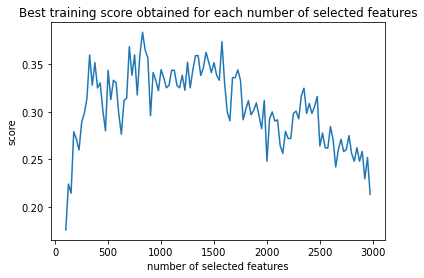

825 0.384
Clustering once
precision:  0.384  recovery:  0.8012820512820513
Clustering 101 times and majority vote
precision:  0.6829268292682927  recovery:  0.26282051282051283


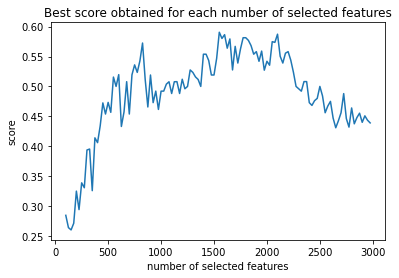

1550 0.5905511811023622
Clustering once
precision:  0.5905511811023622  recovery:  0.8141025641025641
Clustering 101 times and majority vote
precision:  0.8571428571428571  recovery:  0.40384615384615385


In [8]:
N = np.arange(100,3000,25)
for i in range(0,3):
    optimization_onlibrary(name=name_library[i], norm_path=libraries_LSK[i], family_info_path=family_info_LSK[i], flip=False, N)

LSK_exp1_d2_1


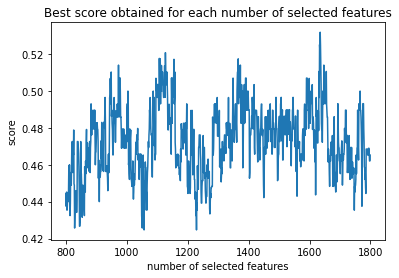

1635 0.5319148936170213
Clustering once
precision:  0.5319148936170213  recovery:  0.7790055248618785
Clustering 101 times and majority vote
precision:  0.8833333333333333  recovery:  0.3314917127071823


In [12]:
#LSK_exp1_d2_1
N = np.arange(800,1800,1)
optimization_onlibrary(name=name_library[0], norm_path=libraries_LSK[0], family_info_path=family_info_LSK[0], flip=False, N=N) 

LSK_exp1_d2_2


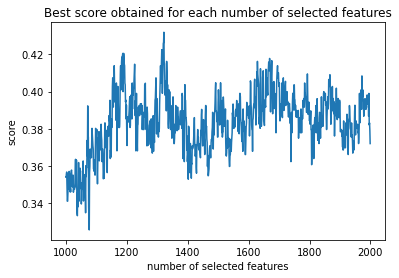

1322 0.431924882629108
Clustering once
precision:  0.431924882629108  recovery:  0.7745454545454545
Clustering 101 times and majority vote
precision:  0.6931818181818182  recovery:  0.32


In [13]:
#LSK_exp1_d2_2
N = np.arange(1000,2000,1)
optimization_onlibrary(name=name_library[1], norm_path=libraries_LSK[1], family_info_path=family_info_LSK[1], flip=False, N=N) 

LSK_exp1_d2_3


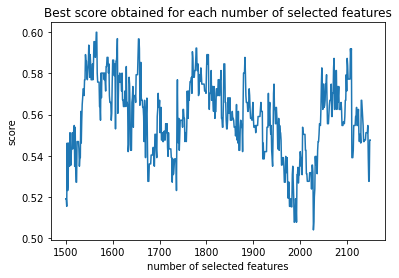

1565 0.6
Clustering once
precision:  0.6  recovery:  0.8333333333333334
Clustering 101 times and majority vote
precision:  0.875  recovery:  0.41025641025641024


In [14]:
#LSK_exp1_d2_3
N = np.arange(1500,2150,1)
optimization_onlibrary(name=name_library[2], norm_path=libraries_LSK[2], family_info_path=family_info_LSK[2], flip=False, N=N)

## Second experiment

In [ ]:
scores = []
lib_name = []
for i in range(3,len(libraries_LSK)):
    score  = prediction_onlibrary(name=name_library[i], norm_path=libraries_LSK[i], family_info_path=family_info_LSK[i], flip=True)
    scores.append(score)

LSK_D2_exp2_library_d2A_1
(23867, 164) (164,)
(23867, 164) (164,)
(164, 1649)
(164, 1766)
LSK_D2_exp2_library_d2A_2
(23867, 321) (321,)
(23867, 321) (321,)
(321, 1530)
(321, 2243)
LSK_D2_exp2_library_d2A_3
(23867, 453) (453,)
(23867, 453) (453,)
(453, 1325)
(453, 2105)
LSK_D2_exp2_library_d2A_4
(23867, 494) (494,)
(23867, 494) (494,)
(494, 2285)
(494, 2418)


In [ ]:
names_scores = ['ML precision', 'ML recovery', 'CV2 precision', 'CV2 recovery']; 
scores = pd.DataFrame(scores, columns = names_scores, index = lib_name)
scores.to_csv('LSK2_pred.csv', index = True)

LSK_exp2_d2A_1


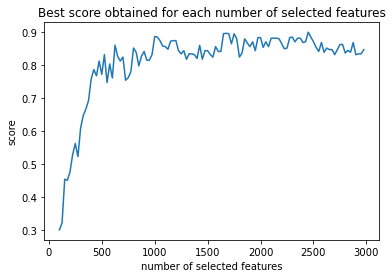

2450 0.8985507246376812
Clustering once
precision:  0.8985507246376812  recovery:  0.8414634146341463
Clustering 101 times and majority vote
precision:  0.9333333333333333  recovery:  0.7317073170731707
LSK_exp2_d2A_2


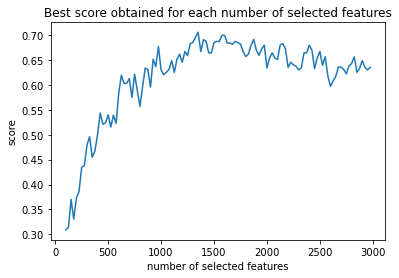

1350 0.7054263565891473
Clustering once
precision:  0.7054263565891473  recovery:  0.8037383177570093
Clustering 101 times and majority vote
precision:  0.8777777777777778  recovery:  0.5607476635514018
LSK_exp2_d2A_3


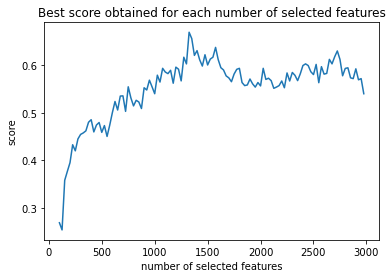

1325 0.6686046511627907
Clustering once
precision:  0.6686046511627907  recovery:  0.7593818984547461
Clustering 101 times and majority vote
precision:  0.8811881188118812  recovery:  0.445916114790287
LSK_exp2_d2A_4


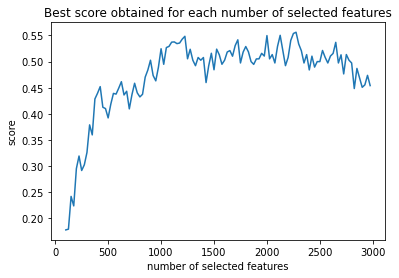

2275 0.5561497326203209
Clustering once
precision:  0.5561497326203209  recovery:  0.757085020242915
Clustering 101 times and majority vote
precision:  0.8526315789473684  recovery:  0.38461538461538464
LSK_exp2_d2A_5


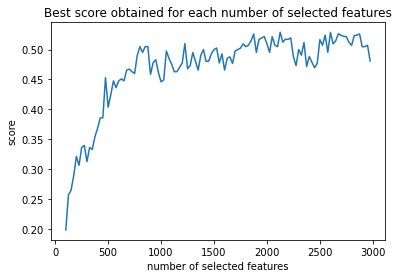

2125 0.5288461538461539
Clustering once
precision:  0.5288461538461539  recovery:  0.7775700934579439
Clustering 101 times and majority vote
precision:  0.8018867924528302  recovery:  0.39626168224299063
LSK_exp2_d2B_1


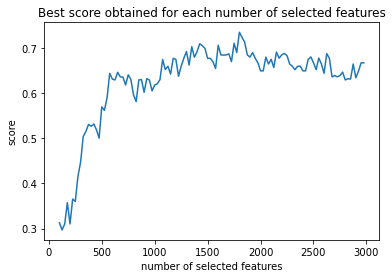

1800 0.734375
Clustering once
precision:  0.734375  recovery:  0.7664670658682635
Clustering 101 times and majority vote
precision:  0.9042553191489362  recovery:  0.562874251497006
LSK_exp2_d2B_2


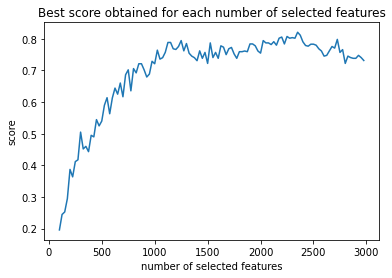

2350 0.8207547169811321
Clustering once
precision:  0.8207547169811321  recovery:  0.8346456692913385
Clustering 101 times and majority vote
precision:  0.8977272727272727  recovery:  0.6929133858267716
LSK_exp2_d2B_3


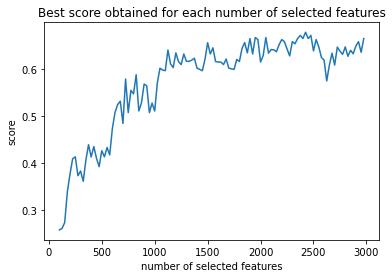

2425 0.6778523489932886
Clustering once
precision:  0.6778523489932886  recovery:  0.7967914438502673
Clustering 101 times and majority vote
precision:  0.8777777777777778  recovery:  0.48128342245989303
LSK_exp2_d2B_4


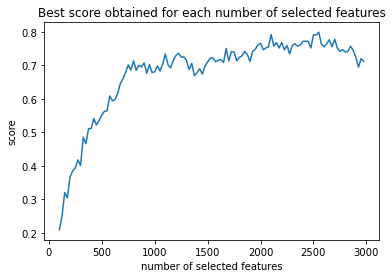

2550 0.7985611510791367
Clustering once
precision:  0.7985611510791367  recovery:  0.8176470588235294
Clustering 101 times and majority vote
precision:  0.900990099009901  recovery:  0.5941176470588235
LSK_exp2_d2B_5


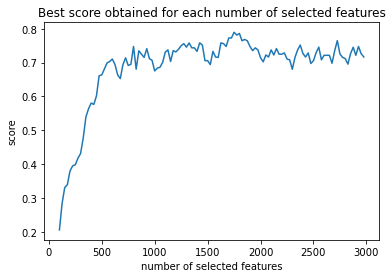

1750 0.7899159663865546
Clustering once
precision:  0.7899159663865546  recovery:  0.8350877192982457
Clustering 101 times and majority vote
precision:  0.9111111111111111  recovery:  0.631578947368421


In [40]:
N = np.arange(100,3000,25)
for i in range(3,len(libraries_LSK)):
    optimization_onlibrary(name=name_library[i], norm_path=libraries_LSK[i], family_info_path=family_info_LSK[i], flip=True, N=N)

LSK_exp2_d2A_1


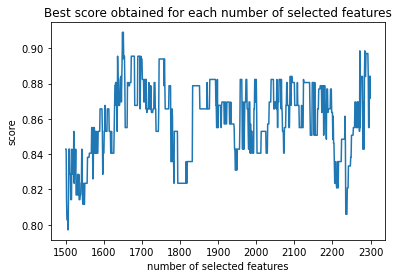

1649 0.9090909090909091
Clustering once
precision:  0.9090909090909091  recovery:  0.8048780487804879
Clustering 101 times and majority vote
precision:  0.9508196721311475  recovery:  0.7439024390243902


In [41]:
N = np.arange(1500,2300,1)
optimization_onlibrary(name=name_library[3], norm_path=libraries_LSK[3], family_info_path=family_info_LSK[3], flip=True, N=N)

LSK_exp2_d2A_2


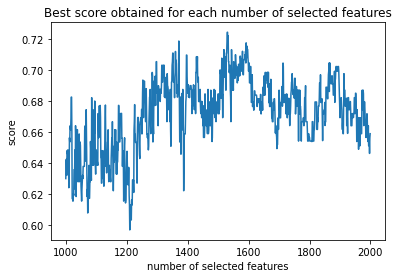

1530 0.7244094488188977
Clustering once
precision:  0.7244094488188977  recovery:  0.7912772585669782
Clustering 101 times and majority vote
precision:  0.8247422680412371  recovery:  0.6043613707165109


In [42]:
N = np.arange(1000,2000,1)
optimization_onlibrary(name=name_library[4], norm_path=libraries_LSK[4], family_info_path=family_info_LSK[4], flip=True, N=N)

LSK_exp2_d2A_3


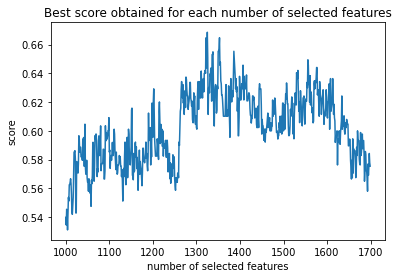

1325 0.6686046511627907
Clustering once
precision:  0.6686046511627907  recovery:  0.7593818984547461
Clustering 101 times and majority vote
precision:  0.9019607843137255  recovery:  0.4503311258278146


In [44]:
N = np.arange(1000,1700,1)
optimization_onlibrary(name=name_library[5], norm_path=libraries_LSK[5], family_info_path=family_info_LSK[5], flip=True, N=N)

LSK_exp2_d2A_4


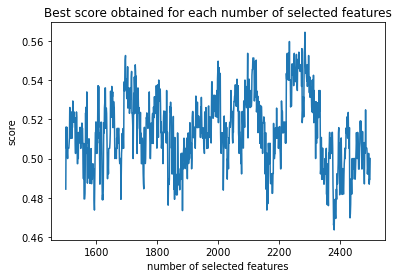

2285 0.5645161290322581
Clustering once
precision:  0.5645161290322581  recovery:  0.7530364372469636
Clustering 101 times and majority vote
precision:  0.865979381443299  recovery:  0.39271255060728744


In [45]:
N = np.arange(1500,2500,1)
optimization_onlibrary(name=name_library[6], norm_path=libraries_LSK[6], family_info_path=family_info_LSK[6], flip=True, N=N)

LSK_exp2_d2A_5


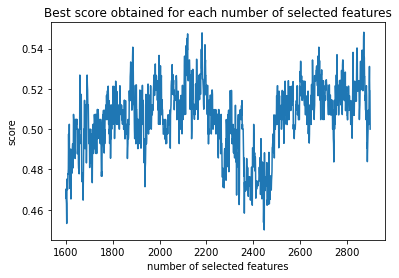

2872 0.5480769230769231
Clustering once
precision:  0.5480769230769231  recovery:  0.7775700934579439
Clustering 101 times and majority vote
precision:  0.7837837837837838  recovery:  0.41495327102803736


In [46]:
N = np.arange(1600,2900,1)
optimization_onlibrary(name=name_library[7], norm_path=libraries_LSK[7], family_info_path=family_info_LSK[7], flip=True, N=N)

LSK_exp2_d2B_1


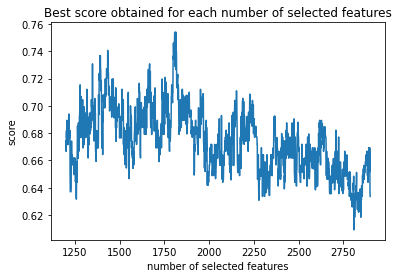

1807 0.753968253968254
Clustering once
precision:  0.753968253968254  recovery:  0.7544910179640718
Clustering 101 times and majority vote
precision:  0.8947368421052632  recovery:  0.5688622754491018


In [47]:
N = np.arange(1200,2900,1)
optimization_onlibrary(name=name_library[8], norm_path=libraries_LSK[8], family_info_path=family_info_LSK[8], flip=True, N=N)

LSK_exp2_d2B_2


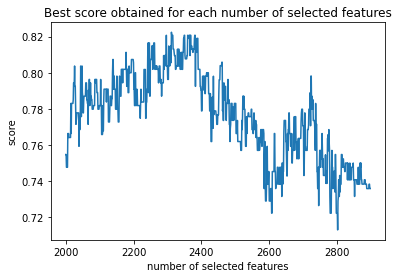

2312 0.822429906542056
Clustering once
precision:  0.822429906542056  recovery:  0.84251968503937
Clustering 101 times and majority vote
precision:  0.8888888888888888  recovery:  0.7086614173228346


In [48]:
N = np.arange(2000,2900,1)
optimization_onlibrary(name=name_library[9], norm_path=libraries_LSK[9], family_info_path=family_info_LSK[9], flip=True, N=N)

LSK_exp2_d2B_3


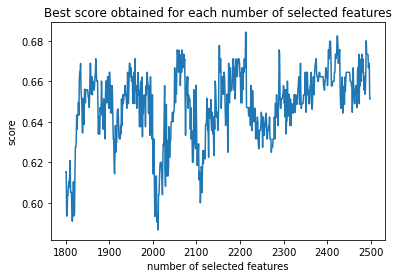

2213 0.6842105263157895
Clustering once
precision:  0.6842105263157895  recovery:  0.8128342245989305
Clustering 101 times and majority vote
precision:  0.86  recovery:  0.5347593582887701


In [49]:
N = np.arange(1800,2500,1)
optimization_onlibrary(name=name_library[10], norm_path=libraries_LSK[10], family_info_path=family_info_LSK[10], flip=True, N=N)

LSK_exp2_d2B_4


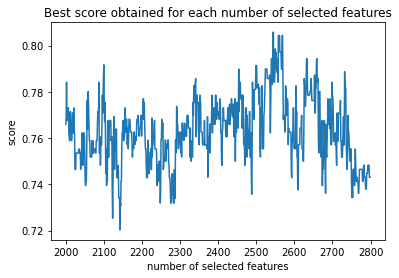

2544 0.8057553956834532
Clustering once
precision:  0.8057553956834532  recovery:  0.8176470588235294
Clustering 101 times and majority vote
precision:  0.900990099009901  recovery:  0.5941176470588235


In [50]:
N = np.arange(2000,2800,1)
optimization_onlibrary(name=name_library[11], norm_path=libraries_LSK[11], family_info_path=family_info_LSK[11], flip=True, N=N)

LSK_exp2_d2B_5


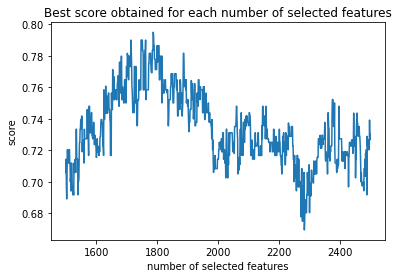

1787 0.7948717948717948
Clustering once
precision:  0.7948717948717948  recovery:  0.8210526315789474
Clustering 101 times and majority vote
precision:  0.9111111111111111  recovery:  0.631578947368421


In [51]:
N = np.arange(1500,2500,1)
optimization_onlibrary(name=name_library[12], norm_path=libraries_LSK[12], family_info_path=family_info_LSK[12], flip=True, N=N)